In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_real_power = pd.read_csv('../debug_logs/real_power.csv', index_col=0)
df_scen = pd.read_csv("../debug_logs/scenarios.csv")
df_quant = pd.read_csv("../debug_logs/quant_next_step.csv")



In [16]:
def quant_from_power(real_power, row, columns):
    for i, quant_bnd in enumerate(columns[2:]):
        quant_val = row[quant_bnd]
        quant_bnd = float(quant_bnd)
        if real_power < quant_val:
            if i == 0:
                bnd_res = quant_bnd
            else:
                bnd_inter = quant_bnd-prev_bnd
                val_inter = quant_val-prev_val
                pow_inter = real_power-prev_val
                bnd_res = pow_inter/val_inter*bnd_inter
            break
        prev_val = quant_val
        prev_bnd = quant_bnd
        bnd_res = quant_bnd
    return bnd_res


In [17]:
# Check if the quantile forecasting is good

tot_steps = 200
real_bnd_counter = list()
sample_bnd_counter = list()
for _, row in df_quant.iterrows():
    build_num = int(row["building"])
    time_step = int(row["time_step"])
    if time_step == tot_steps:
        break

    real_power = df_real_power[f"building_{build_num}"][time_step]
    
    real_bnd = quant_from_power(real_power, row, df_quant.columns)
    real_bnd_counter.append(real_bnd)
    
    same_building = df_scen['time_step'] == time_step
    same_time_step = df_scen['building'] == build_num
    sep_df = list(df_scen.loc[same_building & same_time_step, '+1h'])
    for pow in sep_df:
        pow = float(pow)
        sample_bnd = quant_from_power(pow, row, df_quant.columns)
        sample_bnd_counter.append(sample_bnd)


    


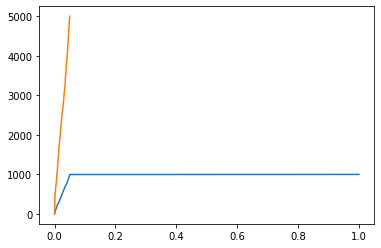

In [20]:
cumulative = np.sort(real_bnd_counter)
y = [i for i, _ in enumerate(cumulative)]
# plot the cumulative function
plt.plot(cumulative, y)

cumulative = np.sort(sample_bnd_counter)
y = [i for i, _ in enumerate(cumulative)]
# plot the cumulative function
plt.plot(cumulative, y)

plt.show()